# Introduction to NetworkX
Networkx is a package that lets you configure, build and analyze complex networks. 

In [1]:
import os, re, sys
import ast
import kmeans

import networkx as nx 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 


from chart_studio.plotly import plotly as py
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe' # This helps plotly render in jupyter for me for some reason


from datetime import datetime as dt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from dotenv import load_dotenv
load_dotenv()

True

Dataset we are using is the MovieMetadata via kaggle: [Here](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv)

In [2]:
cols = ['budget','original_language', 'original_title',
       'production_companies',
        'release_date', 
        'title',
       'genres', 'vote_average'
       ]
df = pd.read_csv('movies_metadata.csv', low_memory=False)[cols]
df=df.loc[df['original_language'] == 'en'].reset_index(drop=True).fillna(-999)

df['date'] = pd.to_datetime(df['release_date'])
df['year'] = df['date'].dt.year
df[:1]

,budget,original_language,original_title,production_companies,release_date,title,genres,vote_average,date,year
0,30000000,en,Toy Story,"[{'name': 'Pixar Animation Studios', 'id': 3}]",1995-10-30,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",7.7,1995-10-30,1995


**Filter down our feature set**

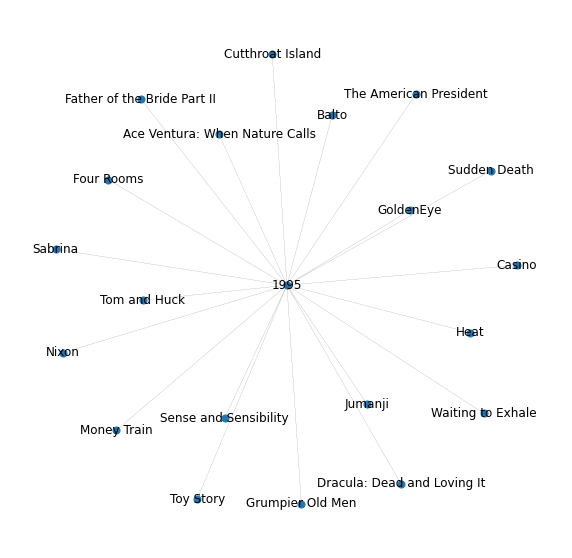

In [3]:
G = nx.from_pandas_edgelist(df[:20], source='title', target='year')
fig,axs = plt.subplots(1,1,figsize=(10,10))
options = {"node_size": 50, "linewidths": 1, "width":.1}
nx.draw(G, with_labels=True, **options)

# Recommender

**Obtain Genera Occurances**

In [4]:
# Pull genres from strings
def get_contents(l): 
    try: 
        dicts = ast.literal_eval(l)
        return [x['name'] for x in dicts if 'name' in x]
    except: 
        return '[]'

df['production_companies_list'] = df['production_companies'].apply(get_contents)
df['genre_list'] = df['genres'].apply(get_contents)
genre_list = list()

# Get unique list of genres
for row in range(len(df)): 
    [genre_list.append(x) for x in df['genre_list'][row] if x not in genre_list]

# Create new series
for genre in genre_list: 
    df[genre] = 0

# Count the occurrences 
for row in range(len(df)): 
    genres = df['genre_list'][row]
    for genre in genres: 
        if genre in genre_list: 
            df[genre][row] = 1
df[['title'] + genre_list]

/var/folders/md/c9lgr11n7x1c0_tghtfh_kjr0000gn/T/ipykernel_47605/1379961408.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,Crime,...,Horror,History,Science Fiction,Mystery,War,Music,Documentary,Foreign,Western,TV Movie
0,Toy Story,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Waiting to Exhale,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Father of the Bride Part II,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32264,Caged Heat 3000,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
32265,Robin Hood,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
32266,Betrayal,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
32267,Satan Triumphant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Reduce genre features by applying PCA**

In [5]:
pca = PCA(n_components=2)
reduction = pca.fit_transform(X=df[genre_list])
reduction = pd.DataFrame(reduction)
df['x'] = reduction[0]
df['y'] = reduction[1]
df[['title','x','y']][:1]

,title,x,y
0,Toy Story,-0.823397,-0.448291


<AxesSubplot:xlabel='x', ylabel='y'>

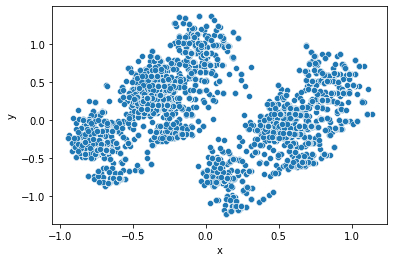

In [6]:
sns.scatterplot(data=df, x='x',y='y')

**Filtering and Cleaning**

In [7]:
df['production_company'] = df['production_companies_list'].str[0]
master = df[['title','x','y','year', 'production_company']].copy()
master = master.loc[master['year'].fillna(0).astype('int') > 1800].copy()
master = master.loc[~master['production_company'].isna()].reset_index(drop=True)

**Optimal Clusters**

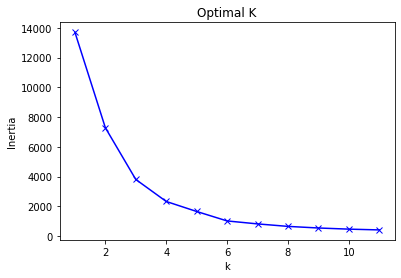

In [8]:
distances = []
K = range(1,12)
for k in K: 
    km = KMeans(n_clusters=k).fit(master[['x','y']])
    distances.append(km.inertia_)

plt.plot(K, distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Optimal K')
plt.show()

Optimal clusters = 4

**Cluster with k=4 clusters**

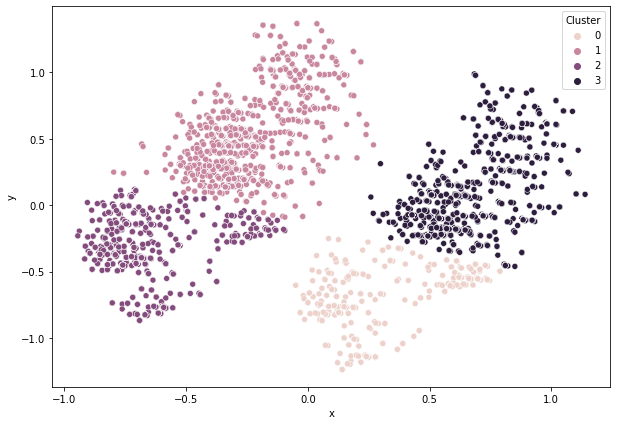

In [9]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(master[['x','y']])
master['cluster'] = kmeans.labels_

fig, ax = plt.subplots(1, 1, figsize=(10,7))
sns.scatterplot(x=master['x'], y=master['y'], hue=master['cluster'], ax=ax)
ax.legend(bbox_to_anchor=(1,1), title='Cluster')

**Visualize Networks**

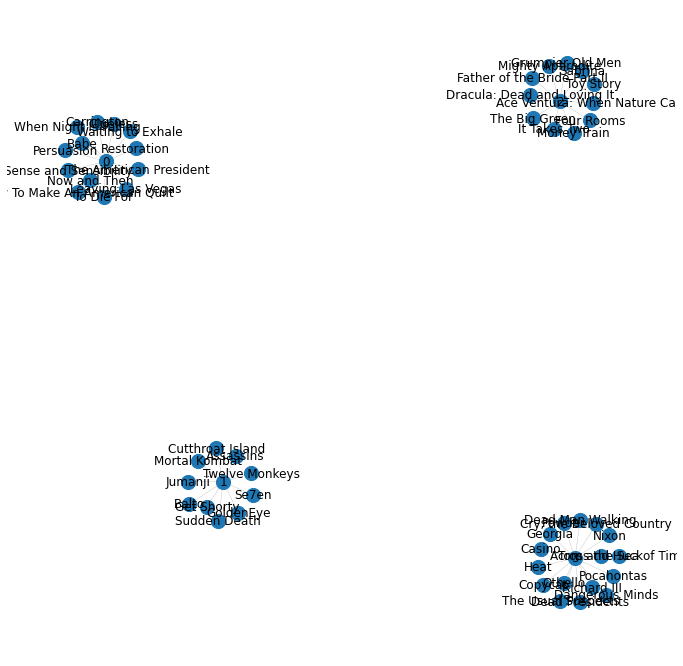

In [10]:
fig,axs = plt.subplots(1,1,figsize=(12,12))
G = nx.from_pandas_edgelist(master[:50], source='cluster', target='title')
options = {"node_size": 200, "linewidths": 1, "width":.1}
nx.draw(G, with_labels=True, **options)

**Adding the Production Company Link**

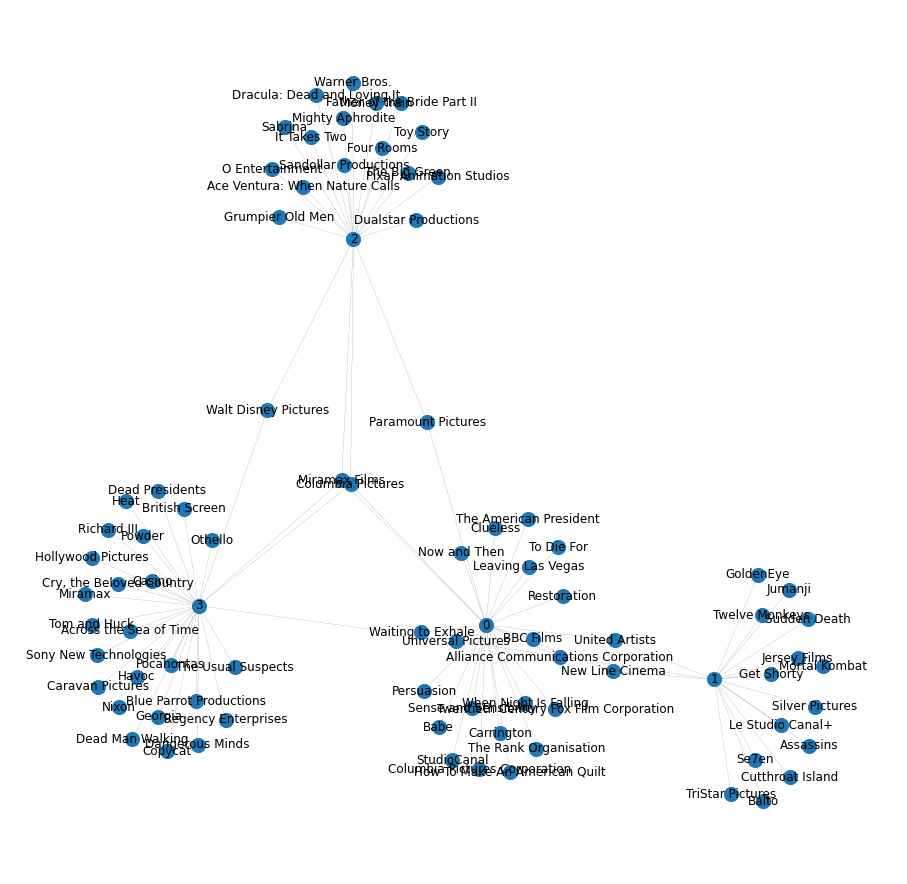

In [11]:
links = list(zip(master['cluster'], master['production_company']))[:50]
fig,axs = plt.subplots(1,1,figsize=(16,16))
G.add_edges_from(links)
options = {"node_size": 200, "linewidths": 1, "width":.1}
nx.draw(G, with_labels=True, **options)

# 3D Network Plots

In [14]:
links = list(zip(master['cluster'], master['production_company']))
G.add_edges_from(links)

In [15]:
# Dim = 3 to specify dimentions
spring_3d = nx.spring_layout(G, dim = 3, k = 0.5)

nodes=list(spring_3d.keys())

# Get Xyz coords
Xn = [spring_3d[x][0] for x in spring_3d]
Yn = [spring_3d[x][1] for x in spring_3d]
Zn = [spring_3d[x][2] for x in spring_3d]

# Create DataFrame
dd = pd.DataFrame([nodes,Xn,Yn,Zn], index=['node','Xn','Yn','Zn']).T
dd['type'] = None
dd['color'] = None

In [16]:
master.shape, len(spring_3d)

((23665, 6), 7496)

In [47]:
l=[x for x in nodes if x  in list(mapping.keys())]

In [48]:
len(l)

7442

In [39]:
# Get type groupings
for i in range(len(dd)): 
    if type(dd['node'][i]) == float: 
        dd['type'][i] = 'cluster'
    else:
        dd['type'][i] = 'title'

In [40]:
companies = df['production_company'].to_list()
mapping = {c:'production' for c in companies}
dd['company'] = dd['node'].map(mapping)

dd.loc[dd['company'].isna() == False, 'type'] = 'production'
dd.loc[dd['type'] == 'cluster', 'color']='yellow'
dd.loc[dd['type'] == 'title', 'color']='blue'
dd.loc[dd['type'] == 'production', 'color']='green'

types = dd['type']
labels = dd['node']

dd[:1]

,node,Xn,Yn,Zn,type,color,company
0,2.0,-0.023664,-0.008897,0.000119,cluster,yellow,NaN


In [41]:
dd

,node,Xn,Yn,Zn,type,color,company
0,2.0,-0.023664,-0.008897,0.000119,cluster,yellow,NaN
1,Toy Story,-0.576059,-0.401841,-0.698706,title,blue,NaN
2,1.0,0.003682,-0.000041,-0.00545,cluster,yellow,NaN
3,Jumanji,0.330928,0.249567,-0.932505,title,blue,NaN
4,Grumpier Old Men,-0.727838,0.24656,0.664978,title,blue,NaN
...,...,...,...,...,...,...,...
7491,The Pacific Trust,0.146155,0.104467,0.974128,production,green,production
7492,Art Pictures Studio,0.238077,-0.105784,-0.855407,production,green,production
7493,Ringling College of Art and Design,-0.755106,-0.5594,0.181398,production,green,production
7494,Neptune Salad Entertainment,-0.867456,0.3321,-0.471478,production,green,production


In [42]:
dd['type'].value_counts()

production    7442
title           50
cluster          4
Name: type, dtype: int64

**Create 2 plots for the Nodes and Edges**

In [20]:
fig1=go.Scatter3d(
                x=dd['Xn'],
               y=dd['Yn'],
               z=dd['Zn'],
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )
fig2=go.Scatter3d(x=dd['Xn'],
               y=dd['Yn'],
               z=dd['Zn'],
               mode='markers',
               name='Title',
               marker=dict(symbol='circle',
                             size=6,
                             color=dd['color'].tolist(),
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )

**Layout Parameters for a 'Blank' background/plot grid**

In [21]:
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
layout = go.Layout(
         title="Network of Clustered Movies by Genre",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
)

**Now we plot**

In [22]:
import chart_studio
chart_studio.tools.set_credentials_file(username='mbooth9993', api_key=os.environ.get("api_key"))
fig = go.Figure(data=[fig1,fig2],layout=layout, ) # 
# py.plot(fig, filename = 'network_large', auto_open=True)
fig